# Select signatures per sample
## Refitting with non-negative least squares regression

In [27]:
from collections import Counter
import json
import itertools
from tqdm.notebook import tqdm
import os

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from scipy.optimize import nnls  # non-negative least squares function

In [3]:
import matplotlib
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

## canonical sorting for contexts

In [4]:
catalog_96channels = []
catalog_96channels_format = []
for snv_type in ['C>A', 'C>G', 'C>T', 'T>A', 'T>C', 'T>G']: 
    ref, alt = snv_type.split('>')
    for nuc5 in ['A', 'C', 'G', 'T']: 
        for nuc3 in ['A', 'C', 'G', 'T']: 
            trinucleotide = nuc5 + ref + nuc3
            catalog_96channels.append(f'{trinucleotide}>{alt}')
            catalog_96channels_format.append(f'{nuc5}[{snv_type}]{nuc3}')

In [5]:
print(catalog_96channels[:10])
print(catalog_96channels_format[:10])

['ACA>A', 'ACC>A', 'ACG>A', 'ACT>A', 'CCA>A', 'CCC>A', 'CCG>A', 'CCT>A', 'GCA>A', 'GCC>A']
['A[C>A]A', 'A[C>A]C', 'A[C>A]G', 'A[C>A]T', 'C[C>A]A', 'C[C>A]C', 'C[C>A]G', 'C[C>A]T', 'G[C>A]A', 'G[C>A]C']


## triplet abundances

### whole-genome abundance

In [14]:
#prepare genome counts to mappable genome
%run ../mutational_profiles/scripts/functions_genome_contexts.py

keys = list(mut_key_gen())
mut_keys = [key[0]+key[1] for key in keys]

mappable_genome_by_chunk_dict = json.load(open('../mutational_profiles/data/hg38_1000kb_bin.filtered.mappable_positions.autosomes.trinuc_per_bin.json','rb'))
contexts = mappable_genome_by_chunk_dict['chr1:3000000-4000000'].keys()
all_contexts_dict = { context:0 for context in contexts}

for chunk in tqdm(mappable_genome_by_chunk_dict.keys()):
    contexts_dict = mappable_genome_by_chunk_dict[chunk]
    for context in contexts:
        all_contexts_dict[context] = contexts_dict[context] + all_contexts_dict[context]
        
map_genome_contexts_dict = {}
for key in keys:
    context = key[0]
    mut = key[1]
    map_genome_contexts_dict[context+mut] = all_contexts_dict[context]
map_genome_contexts_dict

genome_trinuc_counts_96 = [map_genome_contexts_dict[context] for context in map_genome_contexts_dict.keys()]

[83603206,
 46367544,
 9335552,
 67155246,
 73859423,
 52121678,
 9622701,
 71755035,
 58743061,
 46601530,
 8245427,
 56910121,
 81205501,
 62456262,
 8043982,
 92070619,
 83603206,
 46367544,
 9335552,
 67155246,
 73859423,
 52121678,
 9622701,
 71755035,
 58743061,
 46601530,
 8245427,
 56910121,
 81205501,
 62456262,
 8043982,
 92070619,
 83603206,
 46367544,
 9335552,
 67155246,
 73859423,
 52121678,
 9622701,
 71755035,
 58743061,
 46601530,
 8245427,
 56910121,
 81205501,
 62456262,
 8043982,
 92070619,
 88390892,
 54998890,
 76404531,
 106335106,
 53988655,
 67963313,
 82070988,
 84578659,
 47576528,
 38631302,
 60629202,
 60689912,
 89987316,
 83036533,
 78676386,
 162543503,
 88390892,
 54998890,
 76404531,
 106335106,
 53988655,
 67963313,
 82070988,
 84578659,
 47576528,
 38631302,
 60629202,
 60689912,
 89987316,
 83036533,
 78676386,
 162543503,
 88390892,
 54998890,
 76404531,
 106335106,
 53988655,
 67963313,
 82070988,
 84578659,
 47576528,
 38631302,
 60629202,
 60689

### region abundance (sequencing panel)

In [15]:
# get triplet counts from the panel used fo duplex sequencing 
fn = './data/context_twinstrand_mutagenesis_counts.json'

with open(fn, 'rt') as f: 
    region_trinuc_counts = json.load(f)
    
region_trinuc_counts_96 = [region_trinuc_counts[t.split('>')[0]] for t in catalog_96channels]

## signatures
Prepare matrix with signatures from COSMIC

In [17]:
sigs_hg38 = '../../wgs_analysis/tumor_vs_blood/signature_analysis/data/COSMIC_v3.3.1_SBS_GRCh38.txt'
sigs_hg38_df = pd.read_csv(sigs_hg38, sep='\t', header=0)

# aware of the fact that the sorting of contexts might not be the canonical
# we create a new column with the correct index in the canonical context order
# and we sort the entries according to this index

sigs_hg38_df['canonical_index'] = sigs_hg38_df['Type'].apply(lambda r: catalog_96channels_format.index(r))
sigs_hg38_df = sigs_hg38_df.sort_values(by='canonical_index', axis=0)

In [22]:
all_signatures = [c for c in sigs_hg38_df.columns if c.startswith('SBS')]

profiles = []
for signature in all_signatures[:30]:
    hg38_profile = sigs_hg38_df[signature].tolist()    
    profiles.append(hg38_profile)

X = np.array(profiles).T
X.shape

(96, 30)

In [23]:
X

array([[8.76022860e-04, 5.79005909e-07, 2.09197492e-02, ...,
        1.57722172e-04, 6.04617162e-03, 8.44506730e-04],
       [2.22011958e-03, 1.45504532e-04, 1.63431921e-02, ...,
        2.33488181e-03, 9.45179244e-05, 3.97419651e-04],
       [1.79727206e-04, 5.36186073e-05, 1.80754878e-03, ...,
        3.03318755e-04, 7.90362401e-04, 1.02308498e-07],
       ...,
       [5.52133367e-05, 7.12259644e-05, 6.40123040e-03, ...,
        3.85871748e-04, 7.66715982e-04, 5.40179292e-18],
       [5.77613847e-04, 9.54312694e-05, 8.11290411e-03, ...,
        1.31871734e-04, 5.61498393e-03, 1.84448595e-04],
       [2.20126303e-16, 2.22251768e-16, 1.05430872e-02, ...,
        2.22654476e-16, 5.97596882e-04, 7.39116809e-18]])

## mutation counts
Prepare matrix with samples

In [28]:

cols_dict = {'Subtype':'subtype','Context':'context','Sample':'sample','Mut Depth':'mut_depth',
             'Background Count':'BackgroundCount','Mean':'mean','Lower CI':'lower_ci',
            'Upper CI':'upper_ci'}

def make_channels (row):
    mut = row['subtype']
    context = row['context']
    channel = context[0]+'['+mut+']'+context[2]
    return channel

def make_dictionary (df1,context_genome_dict):
         
    
    df1['channels'] = df1.apply(lambda row: make_channels(row),axis=1)
    df1['alt'] = df1['subtype'].str.split('>',expand=True)[1]
    df1['channels2'] = df1['context'] + df1['alt']
    
    #Make dictionary with scaled counts to the panel
    #Transform decimal values (probabilities) as counts, with the proportion of triplet occurences in the genome
    df1['counts'] = df1.apply(lambda row: int(round(row['mean']*context_genome_dict[row['channels2']],0)),axis=1)     
    dictionary = dict(zip(df1['channels'],df1['counts']))
    return dictionary


def create_snv_class(df):
    pyr = ['C', 'T']
    rev = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G', 'N': 'N'}

    x = df['context']

    if x[1] in pyr:
        out = '{}{}{}{}'.format(x[0], x[1], x[2], df['alt'])
    else:
        out = '{}{}{}{}'.format(rev[x[2]], rev[x[1]], rev[x[0]], rev[df['alt']])

    return out

def context_pyr(x):
    pyr = ['C', 'T']
    rev = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G', 'N': 'N'}

    if x[1] in pyr:
        return x
    else:
        return rev[x[2]]+rev[x[1]]+rev[x[0]]
    
def prepare_count_table(path):
    df = pd.read_csv(path,sep='\t')
    df['vaf'] = df['alt_depth'] / df['depth']
    df = df.rename(columns={'context':'context2'})
    df['context'] = df['context2'].apply(lambda x: context_pyr (x))
    
    path2 = path.replace('.mut','.genome.mut')
    df2 = pd.read_csv(path2,sep='\t')
    df2 = df2.rename(columns={'context':'context2'})
    df2['context'] = df2['context2'].apply(lambda x: context_pyr (x))    

    df2 = df2[['context','depth']].groupby('context',as_index=False).sum()
    depth_dict = dict(zip(df2['context'],df2['depth']))

    df = df[(df['vaf']<0.35)&(df['variation_type']=='snv')]
    df['channels'] = df.apply(create_snv_class, axis=1)

    cat_type = CategoricalDtype(categories=mut_keys, ordered=True)
    df['channels'] = df['channels'].astype(cat_type)
    df1 = df[['channels','subtype']].groupby(['channels'],as_index=False).count()
    df1 = df1.rename(columns={'subtype':'mut_count'})
    df1['context'] = df1['channels'].apply(lambda x: x[:-1])
    df1['subtype'] = df1['channels'].apply(lambda x: x[1]+'>'+x[3])
    df1['BackgroundCount'] = df1['context'].map(depth_dict)
    df1['mean'] = df1['mut_count'] / df1['BackgroundCount']
    return df1 

In [100]:
#calculate counts relative to mappable genome
all_files = []
matrix_df = pd.DataFrame()
path = '../mutational_profiles/output_dnanexus/'
for file in os.listdir(path):
    if file.endswith('variant-calls.mut'):
        df1 = prepare_count_table(path+file)
        dictionary1 = make_dictionary(df1,map_genome_contexts_dict)
        sample = file.split('.1')[0]
        if sample.startswith('CHp'):
            names_dict = {'CHp_39_T0':'AZ6342','CHp_38_T0':'AZ6371'}
            sample = names_dict[sample]
        df1 = pd.DataFrame.from_dict(dictionary1,orient='index',columns=[sample])
        df1 = df1.T
        matrix_df = pd.concat([matrix_df,df1])
matrix_df.sort_index(inplace=True)
matrix_df

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (26,32,37) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (26,37) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (32) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
AU2198,8,11,9,0,18,42,5,32,8,9,...,3,8,0,0,0,0,0,0,0,3
AU2199,33,11,24,5,47,26,13,13,13,12,...,0,0,0,0,0,0,0,0,0,0
AU2200,6,2,16,16,10,21,10,16,11,4,...,8,6,2,4,0,2,2,4,4,5
AU2202,4,3,4,2,1,4,1,5,3,1,...,1,1,1,3,0,1,1,1,0,2
AZ4609,19,21,5,30,17,35,6,32,31,54,...,10,10,10,6,2,3,4,12,5,11
AZ4610,20,20,5,14,9,54,9,50,18,38,...,4,13,7,8,10,4,7,2,4,2
AZ4611,12,11,6,9,13,23,5,15,10,10,...,5,7,2,7,4,0,2,3,0,4
AZ4612,32,0,0,6,12,6,18,30,6,13,...,12,23,7,12,0,12,7,6,12,15
AZ4613,10,0,13,10,0,10,0,15,9,11,...,0,9,0,0,5,5,0,9,0,6
AZ4614,11,9,6,10,2,5,3,15,8,9,...,2,5,0,7,0,2,2,2,0,2


In [101]:
sample_ids = matrix_df.index.tolist()
sample_ids

['AU2198',
 'AU2199',
 'AU2200',
 'AU2202',
 'AZ4609',
 'AZ4610',
 'AZ4611',
 'AZ4612',
 'AZ4613',
 'AZ4614',
 'AZ6342',
 'AZ6371']

In [102]:
Y = matrix_df.T.to_numpy()
Y

array([[ 8, 33,  6, ..., 11,  5,  0],
       [11, 11,  2, ...,  9,  4,  3],
       [ 9, 24, 16, ...,  6,  3,  2],
       ...,
       [ 0,  0,  4, ...,  2,  1,  0],
       [ 0,  0,  4, ...,  0,  0,  0],
       [ 3,  0,  5, ...,  2,  0,  0]])

# **signature refitting with model selection**

In linear regression with gaussian errors there is an expression for Akaike Information Criterion (AIC) as follows

$$
AIC = n \log(\hat{\sigma}^2) + 2k
$$

$k$ is the number of model parameters (number of signatures),

$n$ is the number of samples,

$\hat{\sigma}^2$ is the mean residual sum of squares, i.e., RSS / $n$

**Strategy:** Given a set of candidate signatures, we can proceed as in Rabhari et al.: take all possible combinations with a reducted number of signatures, compute AIC in each case and select the model with least AIC.

In [103]:
def aic_linear_model(X, y, fit):
    
    """
    X: signature profile design matrix
    y: vector of counts
    fit: OLS fit
    """
    
    k = X.shape[1]
    n = X.shape[0]
    
    error = np.dot(fit, X.T) - y.T
    sigma_hat = np.sum(error ** 2) / n
        
    return n * np.log(sigma_hat) + 2 * k


def fit_nnls(X, Y):

    fit_list, aic = [], []
    for j in range(Y.shape[1]):
        y = Y.T[j,:]
        fit = np.array(list(nnls(X, y)[0]))
        fit_list.append(fit)
        aic.append(aic_linear_model(X, y, fit))
        
    return np.array(fit_list), np.min(aic)

### fitting for all combinations of 1 - 8 signatures

In [35]:
def fitting_combinations (Y,N,candidate_signatures,sigs_hg38_df,genome_trinuc_counts_96,region_trinuc_counts_96):
    '''
    Y: array with rows as triplet contexts and column as sample/samples
    N: integer, number of signatures to be combined
    candidate_signatures: list of strings, signatures to be tested
    sigs_hg38_df: df all signatures from COSMIC
    genome_trinuc_counts_96: list of integers, triplet counts on genome
    region_trinuc_counts_96: list of integers, triplet counts on the region
    '''
    norm_profiles = {}
    for sig in candidate_signatures:
        hg38_profile = sigs_hg38_df[sig].tolist()    
        norm_profile = [p * trinuc_a / trinuc_g for p, trinuc_g, trinuc_a in zip(hg38_profile, 
                                                                                 genome_trinuc_counts_96, 
                                                                                 region_trinuc_counts_96)]
        norm_profile = [p / sum(norm_profile) for p in norm_profile]
        norm_profiles[sig] = norm_profile

    res = []
    for k in range(1, N+1):
        print(f'checking {k} signature combinations')
        for combination in tqdm(itertools.combinations(candidate_signatures, k)):
            profiles = []
            for sig in combination:
                profiles.append(norm_profiles[sig])
            X = np.array(profiles).T
            fit, aic = fit_nnls(X, Y)
            res.append((combination, fit, aic))
    return res

In [104]:
N = 8
candidate_signatures = ['SBS1','SBS2','SBS5','SBS13','SBS18','SBS31','SBS35','SBS40','SBS45']
res_dict = {}
n = 0
for sample in sample_ids:
    Y1 = Y[:,n].reshape(-1,1)
    res = fitting_combinations (Y1,N,candidate_signatures,sigs_hg38_df,genome_trinuc_counts_96,region_trinuc_counts_96)
    res_dict[sample] = res
    n = n+1
res_dict

checking 1 signature combinations



checking 2 signature combinations



checking 3 signature combinations



checking 4 signature combinations



checking 5 signature combinations



checking 6 signature combinations



checking 7 signature combinations



checking 8 signature combinations



checking 1 signature combinations



checking 2 signature combinations



checking 3 signature combinations



checking 4 signature combinations



checking 5 signature combinations



checking 6 signature combinations



checking 7 signature combinations



checking 8 signature combinations



checking 1 signature combinations



checking 2 signature combinations



checking 3 signature combinations



checking 4 signature combinations



checking 5 signature combinations



checking 6 signature combinations



checking 7 signature combinations



checking 8 signature combinations



checking 1 signature combinations



checking 2 signature combinations



checking 3 signature combinations



checking 4 signature combinations



checking 5 signature combinations



checking 6 signature combinations



checking 7 signature combinations



checking 8 signature combinations



checking 1 signature combinations



checking 2 signature combinations



checking 3 signature combinations



checking 4 signature combinations



checking 5 signature combinations



checking 6 signature combinations



checking 7 signature combinations



checking 8 signature combinations



checking 1 signature combinations



checking 2 signature combinations



checking 3 signature combinations



checking 4 signature combinations



checking 5 signature combinations



checking 6 signature combinations



checking 7 signature combinations



checking 8 signature combinations



checking 1 signature combinations



checking 2 signature combinations



checking 3 signature combinations



checking 4 signature combinations



checking 5 signature combinations



checking 6 signature combinations



checking 7 signature combinations



checking 8 signature combinations



checking 1 signature combinations



checking 2 signature combinations



checking 3 signature combinations



checking 4 signature combinations



checking 5 signature combinations



checking 6 signature combinations



checking 7 signature combinations



checking 8 signature combinations



checking 1 signature combinations



checking 2 signature combinations



checking 3 signature combinations



checking 4 signature combinations



checking 5 signature combinations



checking 6 signature combinations



checking 7 signature combinations



checking 8 signature combinations



checking 1 signature combinations



checking 2 signature combinations



checking 3 signature combinations



checking 4 signature combinations



checking 5 signature combinations



checking 6 signature combinations



checking 7 signature combinations



checking 8 signature combinations



checking 1 signature combinations



checking 2 signature combinations



checking 3 signature combinations



checking 4 signature combinations



checking 5 signature combinations



checking 6 signature combinations



checking 7 signature combinations



checking 8 signature combinations



checking 1 signature combinations



checking 2 signature combinations



checking 3 signature combinations



checking 4 signature combinations



checking 5 signature combinations



checking 6 signature combinations



checking 7 signature combinations



checking 8 signature combinations


{'AU2198': [(('SBS1',), array([[38.41673896]]), 429.97876592796354),
  (('SBS2',), array([[34.60724449]]), 428.73055404216973),
  (('SBS5',), array([[350.26484248]]), 407.7346467678367),
  (('SBS13',), array([[6.38251039]]), 433.84792409176754),
  (('SBS18',), array([[164.5214502]]), 417.450323429826),
  (('SBS31',), array([[289.26351095]]), 353.3729255411133),
  (('SBS35',), array([[322.96340331]]), 372.9714515369204),
  (('SBS40',), array([[445.3781985]]), 393.1191461955041),
  (('SBS45',), array([[142.0689026]]), 398.2517800013485),
  (('SBS1', 'SBS2'), array([[37.44428734, 33.94015715]]), 426.7389109323068),
  (('SBS1', 'SBS5'), array([[ 18.96129982, 334.6959439 ]]), 408.5384908334473),
  (('SBS1', 'SBS13'), array([[38.37537402,  6.13268598]]), 431.87139602952004),
  (('SBS1', 'SBS18'),
   array([[ 28.39808059, 155.9178623 ]]),
   416.93641561666436),
  (('SBS1', 'SBS31'),
   array([[ 29.08135354, 285.40729465]]),
   350.0790204557589),
  (('SBS1', 'SBS35'),
   array([[ 35.37226637

## Get consensus fitting across the best solutions

In [105]:
def best_models (sample_id,res,n_best_models=None):
    sorted_models = sorted(res, key=lambda x: x[2])
    lowest_aic = sorted_models[0][2]
    sorted_best_models = [(combination, fit_array, aic) for combination, fit_array, aic in sorted_models if aic - lowest_aic < 5]
    
    if n_best_models!=None:
        sorted_best_models = sorted_best_models[0:n_best_models]
        
    consensus_dict = {}
    for combination, fit_array, aic in sorted_best_models:
        for i, sig in enumerate(combination):
            consensus_dict[sig] = consensus_dict.get(sig, []) + [fit_array[:,i]]

    """
    for sig in consensus_dict:
        consensus_dict[sig] = np.mean(consensus_dict[sig], axis=0)
    """

    consensus_dict
    sigs, counts = [], []
    for k, arr in consensus_dict.items():
        sigs.append(k)
        counts.append(len(arr))

    plt.figure(figsize=(12,4))
    plt.bar(range(len(sigs)), counts)
    plt.xticks(range(len(sigs)), sigs, rotation=90)
    plt.title(sample_id+'\nsignature usage in best models')
    plt.ylabel('How many times is used across best models')
    plt.show()
    
    return sorted_best_models

In [106]:
res_dict.keys()

dict_keys(['AU2198', 'AU2199', 'AU2200', 'AU2202', 'AZ4609', 'AZ4610', 'AZ4611', 'AZ4612', 'AZ4613', 'AZ4614', 'AZ6342', 'AZ6371'])

In [107]:
sample_dict = {'AU2198':'Case2,Blood',
              'AU2199':'Case2,Tumor1',
              'AU2200':'Case2,Tumor2',
              'AU2202':'Case3,Tumor2',
              'AZ4609':'Case3,Kidney',
              'AZ4610':'Case3,Liver',
              'AZ4611':'Case3,Pancreas',
              'AZ4612':'Case3,Lung',
              'AZ4613':'Case3,Spleen',
              'AZ4614':'Case3,BoneMarrow',
              'AZ6342':'Unrelated,Blood,NonTreated',
              'AZ6371':'Unrelated,Blood,NonTreated'}

In [108]:
candidate_signatures

['SBS1', 'SBS2', 'SBS5', 'SBS13', 'SBS18', 'SBS31', 'SBS35', 'SBS40', 'SBS45']

16
(('SBS1', 'SBS2', 'SBS31', 'SBS45'), array([[ 27.43006223,  24.54999847, 255.57026584, 117.1267423 ]]), 272.86842800781676)


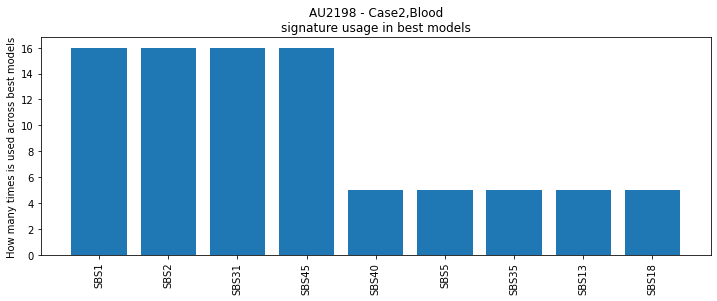

33
(('SBS2', 'SBS18', 'SBS40', 'SBS45'), array([[ 53.51412157, 156.31435965, 382.51551453,  86.4766758 ]]), 403.95927092194415)


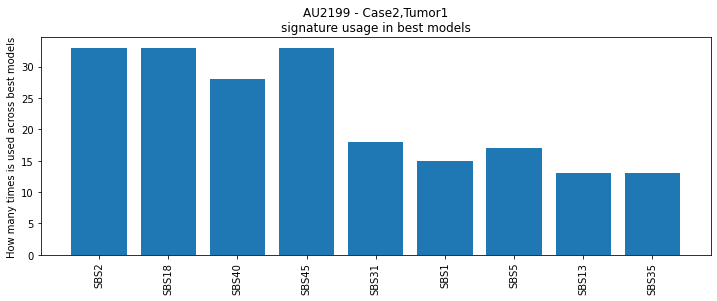

14
(('SBS1', 'SBS2', 'SBS5', 'SBS18', 'SBS31', 'SBS45'), array([[ 15.5475806 ,  14.18766068, 212.78622054,  65.15353328,
         46.76582807,  54.39624825]]), 250.33636974457693)


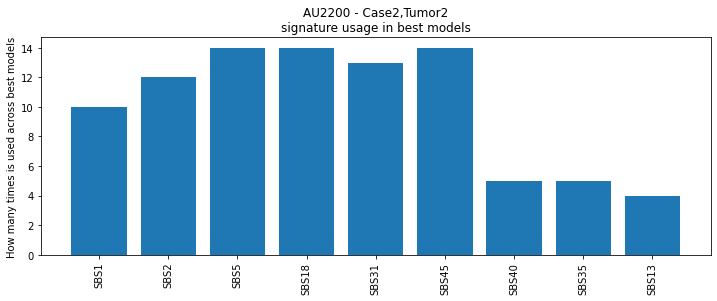

34
(('SBS1', 'SBS2', 'SBS5', 'SBS18', 'SBS31', 'SBS40'), array([[ 7.80172388,  4.75411361, 38.93087426, 50.31736863, 17.40979109,
        56.93366391]]), 86.89143218747185)


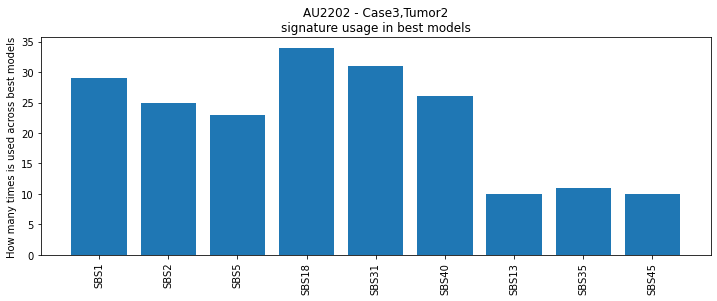

26
(('SBS5', 'SBS18', 'SBS35', 'SBS40'), array([[445.73585162, 128.93417139, 254.2719448 , 252.41025611]]), 392.2367100047985)


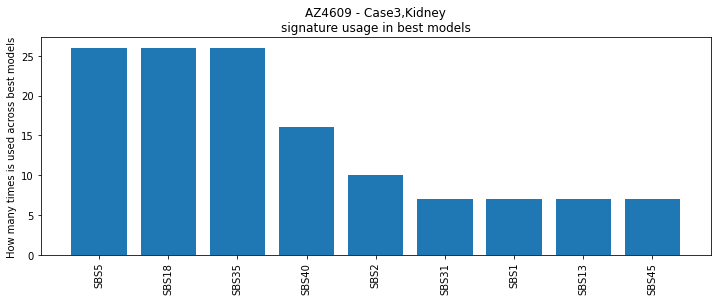

20
(('SBS5', 'SBS31', 'SBS35', 'SBS40', 'SBS45'), array([[318.51358296, 162.44064977, 147.25956562, 206.72916603,
         89.22641145]]), 380.2488495609524)


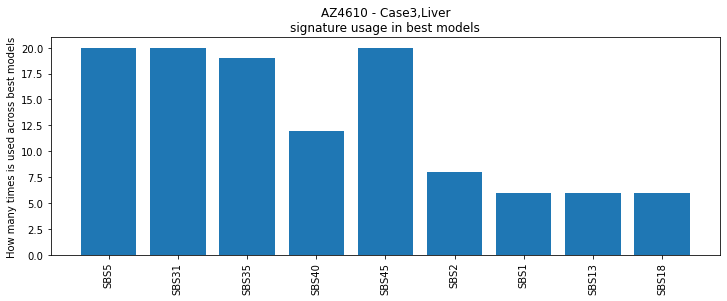

35
(('SBS5', 'SBS31', 'SBS40', 'SBS45'), array([[103.5780136 , 102.55586729, 208.29626967,  52.13835094]]), 248.2284522806836)


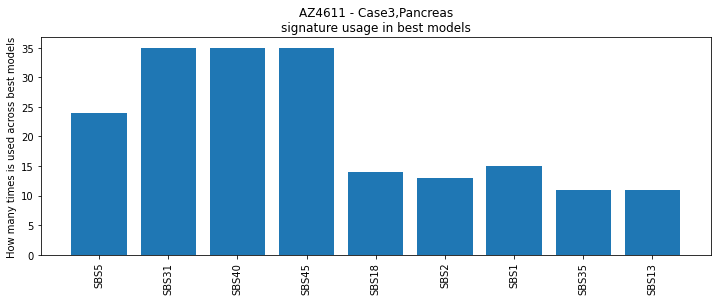

117
(('SBS1', 'SBS31', 'SBS35', 'SBS40'), array([[ 27.06133366,  62.40806002,  93.22803432, 591.31762208]]), 391.76721409714537)


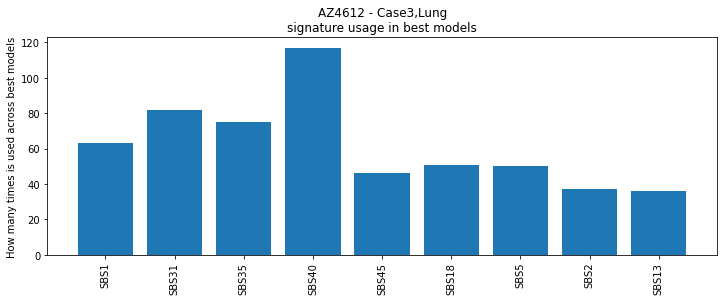

70
(('SBS2', 'SBS13', 'SBS31', 'SBS40'), array([[ 19.68027186,  15.49664637,  61.07097164, 273.58343465]]), 283.4384758544839)


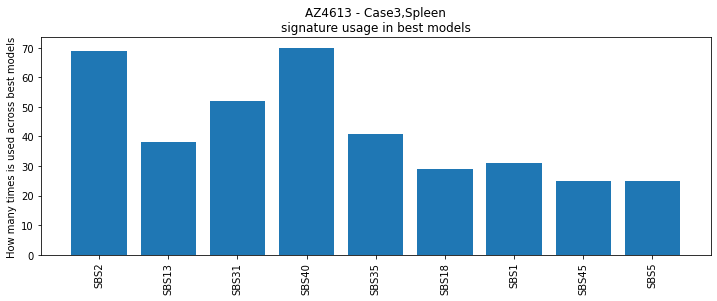

45
(('SBS5', 'SBS18', 'SBS35', 'SBS40'), array([[ 81.77168812,  36.65297339,  66.96405015, 133.88283204]]), 191.4689414762211)


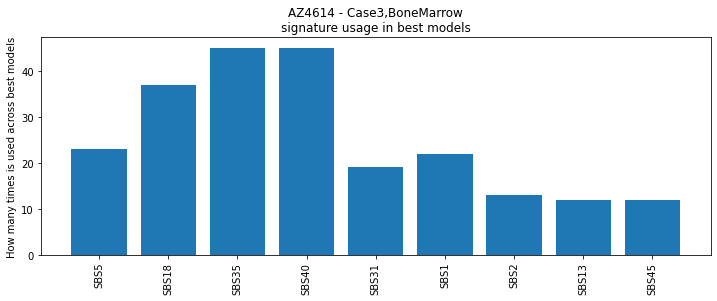

61
(('SBS5', 'SBS18', 'SBS35'), array([[103.39451382,  26.73959818,  25.28823108]]), 114.73664873016844)


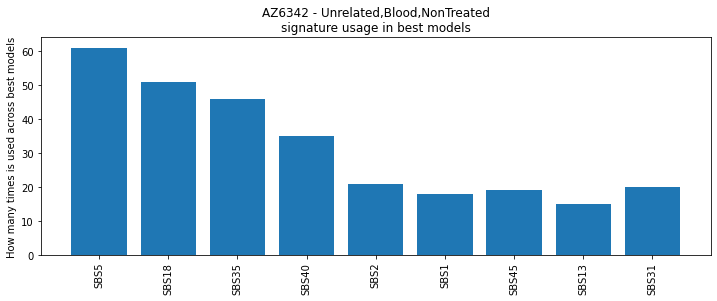

47
(('SBS31', 'SBS40'), array([[16.50089569, 39.06165677]]), 23.811609414931215)


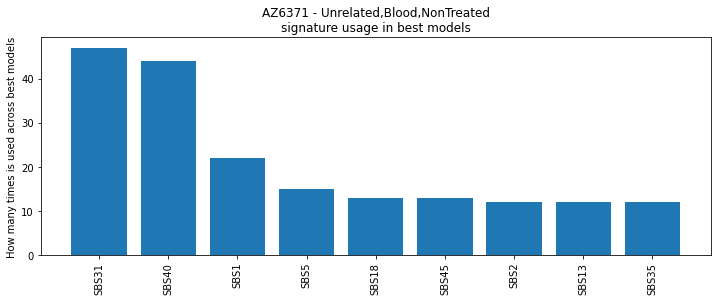

In [109]:
best_models_dict = {}
for sample_id in sample_ids:
    sample_type = sample_dict[sample_id]
    tumor2_list = sorted(res_dict[sample_id],key=lambda x:x[2])
    aic_min=tumor2_list[0][2]
    res_sample = [item for item in tumor2_list if item[2] - aic_min <= 5]
    print(len(res_sample))
    print(res_sample[0])
    sorted_best_models = best_models(sample_id+' - '+sample_type,res_sample)
    best_models_dict[sample_id] = sorted_best_models

### Show most frequent combinations

In [45]:
import itertools as itt

In [46]:
def best_sig_combinations (sample_ids, sample_dict,res_dict,num_sigs):
    best_models_dict = {}
    for sample_id in sample_ids:
        sample_type = sample_dict[sample_id]
        tumor2_list = sorted(res_dict[sample_id],key=lambda x:x[2])
        aic_min=tumor2_list[0][2]
        res_sample = [item for item in tumor2_list if item[2] - aic_min <= 5]

        good_sets = [set(r[0]) for r in res_sample]
        freq_dict = {}
        for item in itt.combinations(candidate_signatures, num_sigs):
            freq = 0
            for good_set in good_sets:
                s = set(item)
                if s.issubset(good_set):
                    freq += 1
            freq_dict[item] = freq
        freq_sorted = sorted(freq_dict.items(), key=lambda x:x[1],reverse=True)
        freq_sorted2 = [(f[0],f[1]) for f in freq_sorted if f[1]>=5]
        freq_sorted_dict = dict(freq_sorted2)
        if len(freq_sorted_dict)>50:
            selected_keys = list(freq_sorted_dict.keys())
            selected_keys = selected_keys[0:50]
            freq_sorted_dict = {k:v for k,v in freq_sorted_dict.items() if k in selected_keys}
        plt.figure(figsize = (12,4))
        plt.bar(range(len(freq_sorted_dict)),list(freq_sorted_dict.values()),align='center')
        plt.xticks(range(len(freq_sorted_dict)), list(freq_sorted_dict.keys()),rotation=90)
        plt.title(sample_id +' '+sample_type+ ' '+str(num_sigs)+' signatures')
        plt.show()

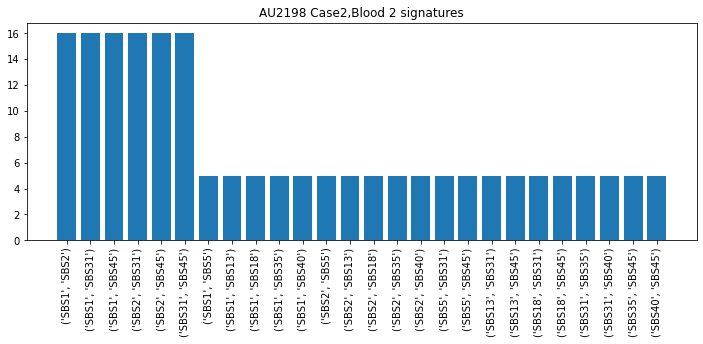

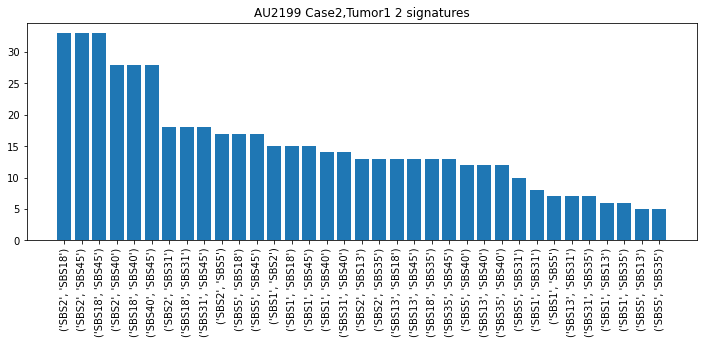

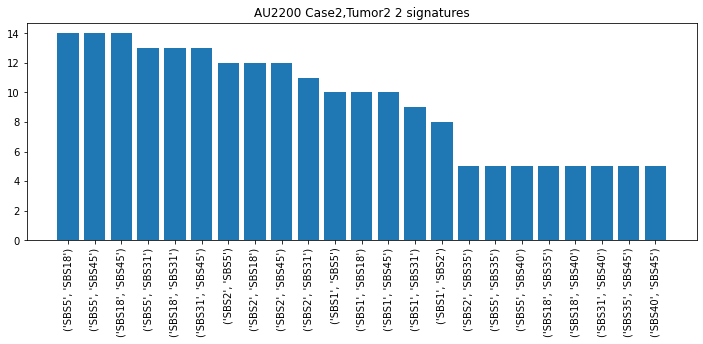

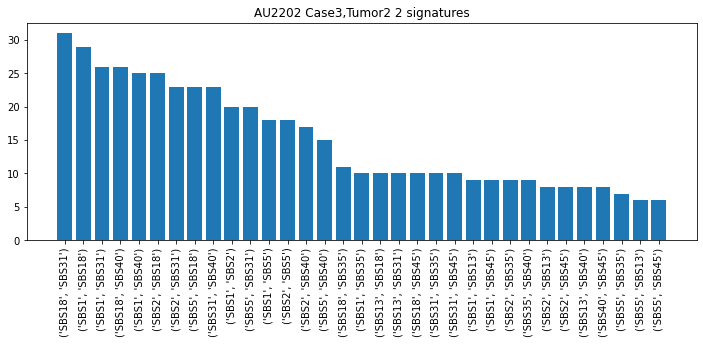

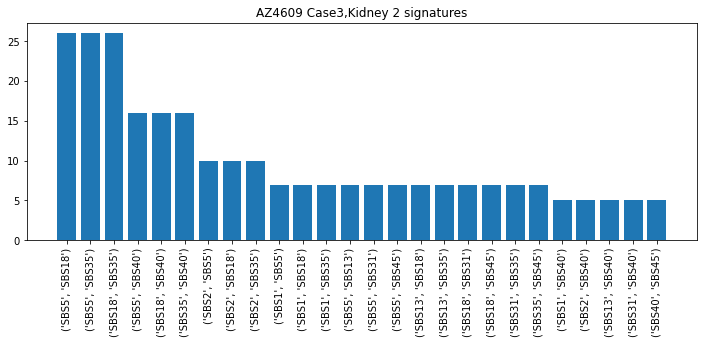

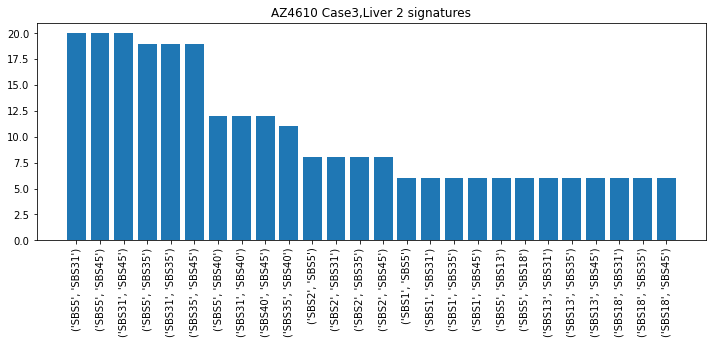

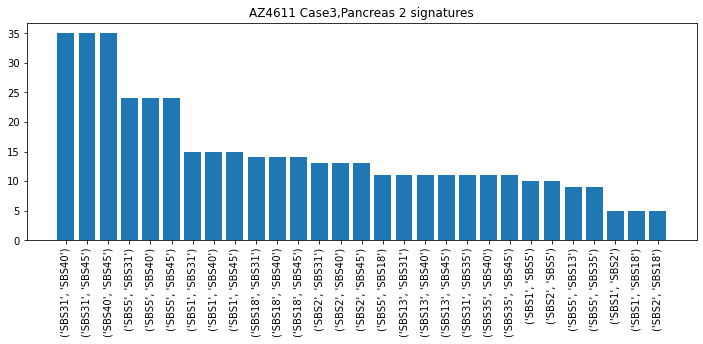

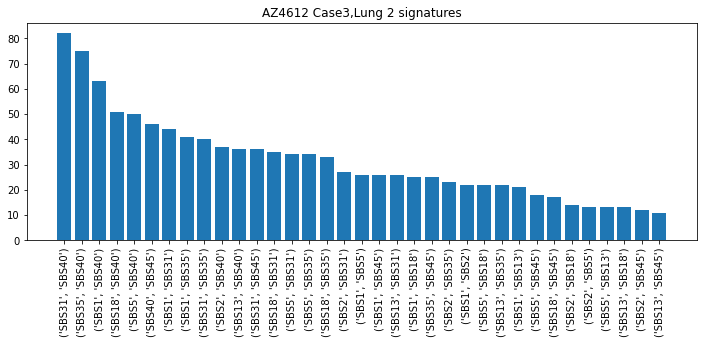

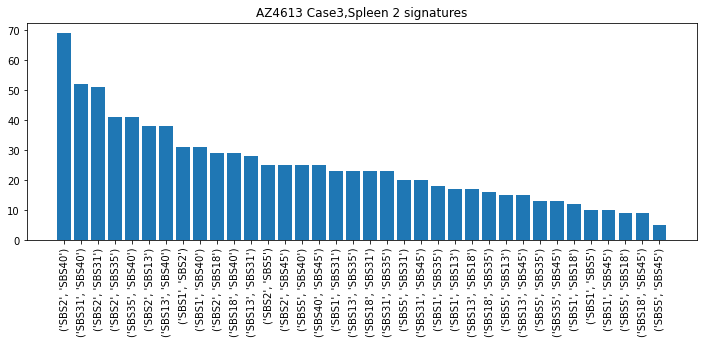

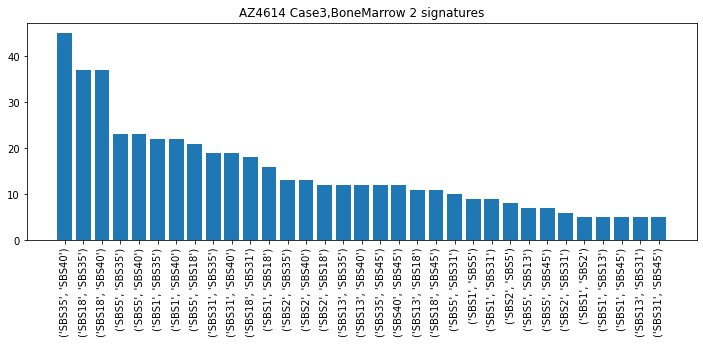

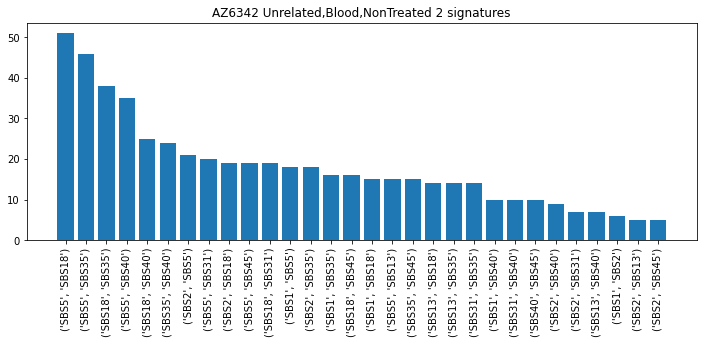

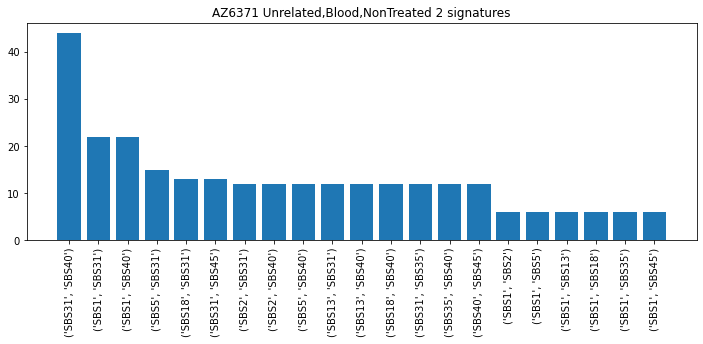

In [110]:
num_sigs = 2
best_sig_combinations (sample_ids, sample_dict,res_dict,num_sigs)

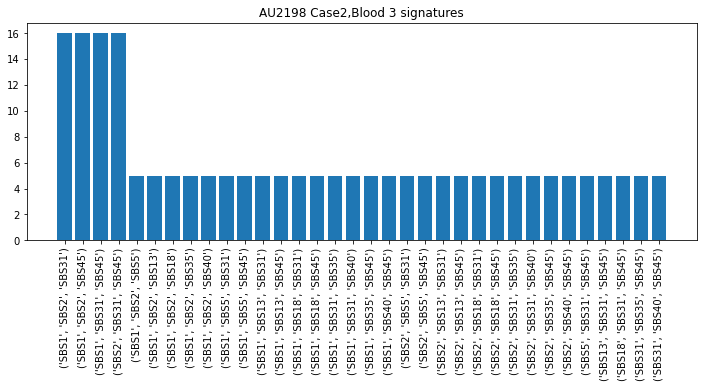

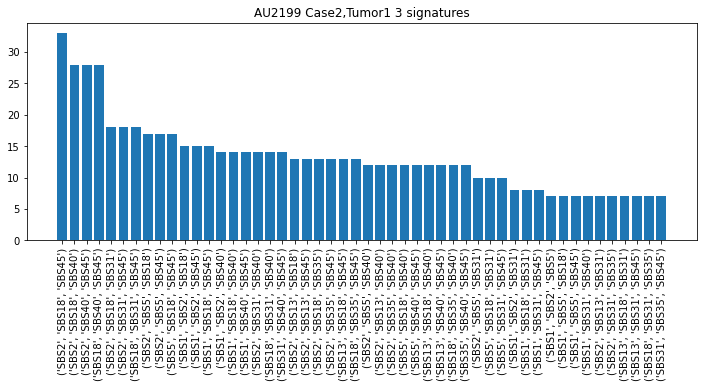

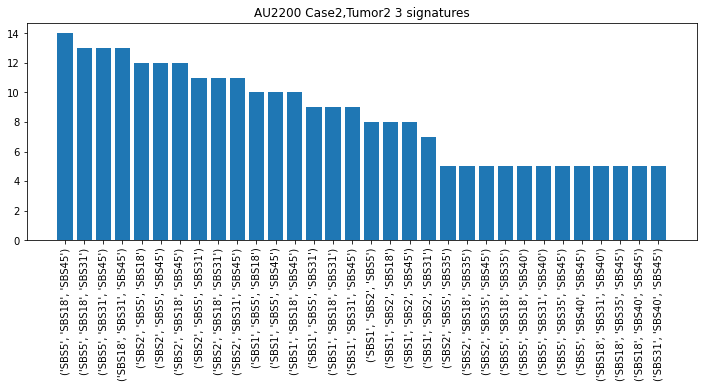

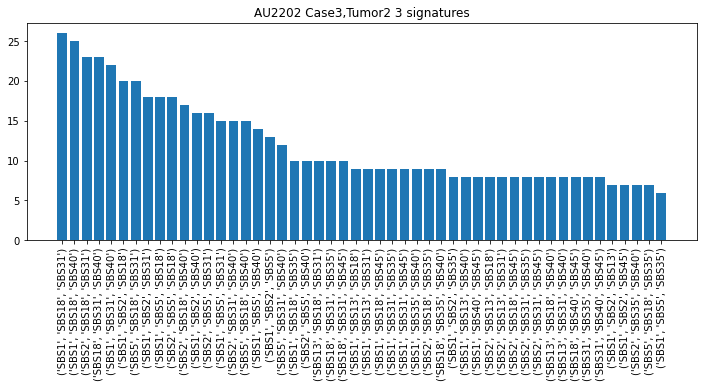

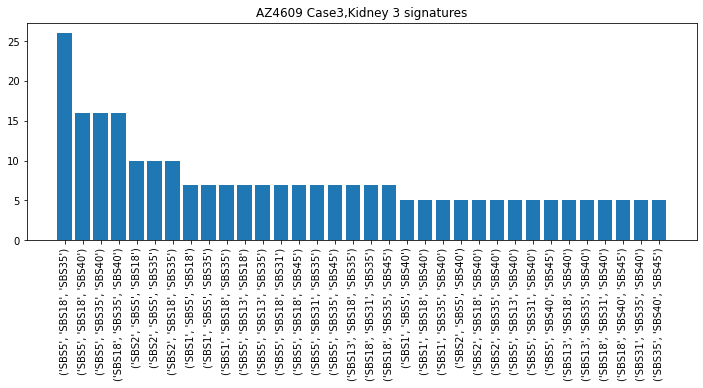

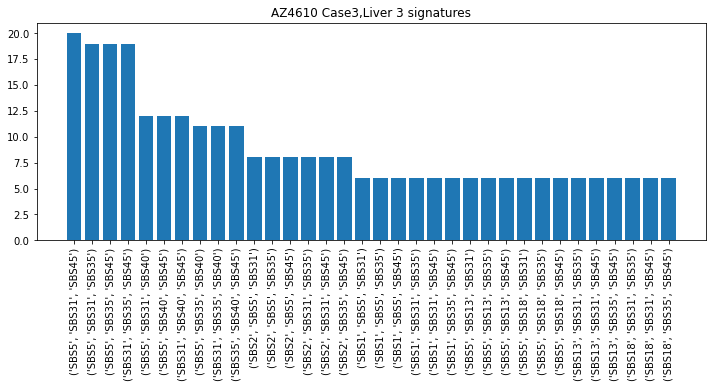

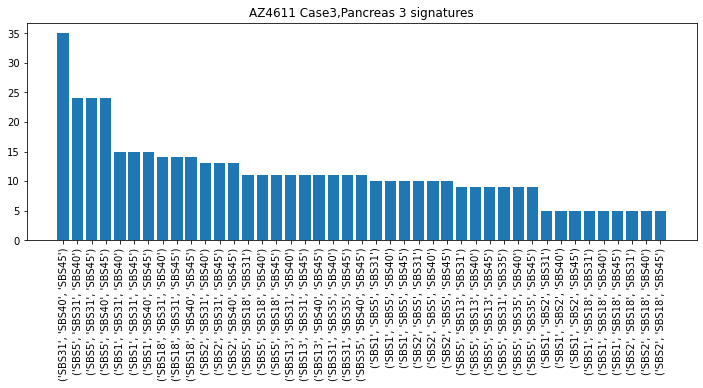

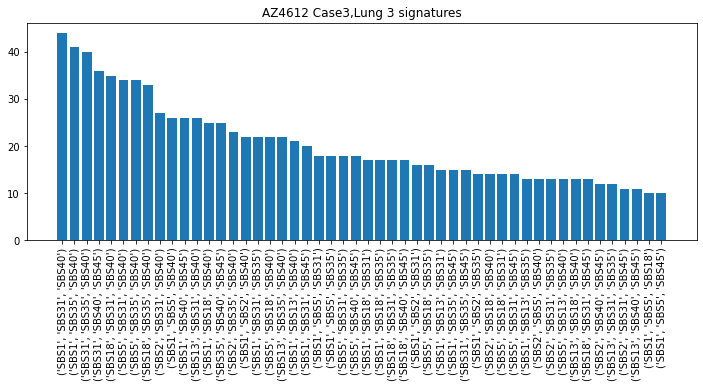

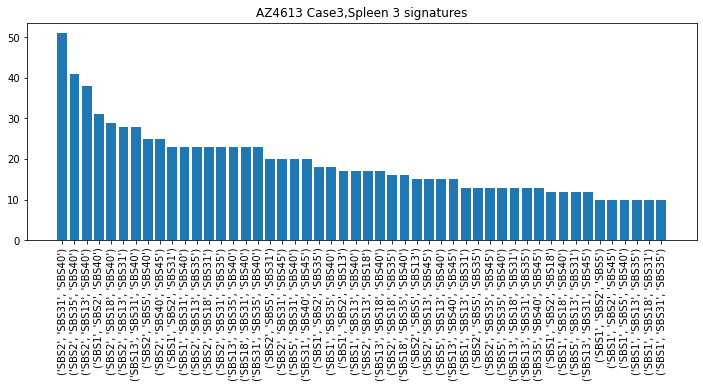

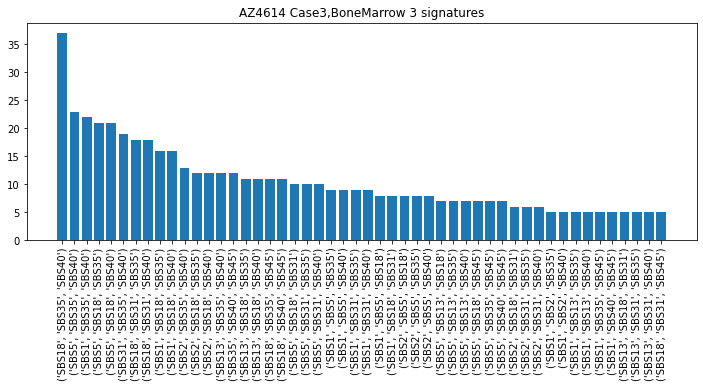

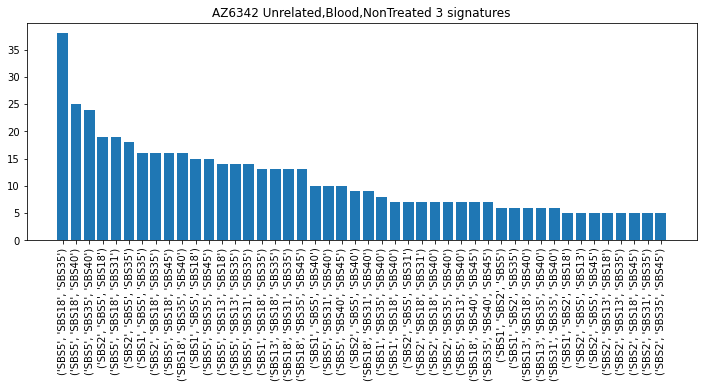

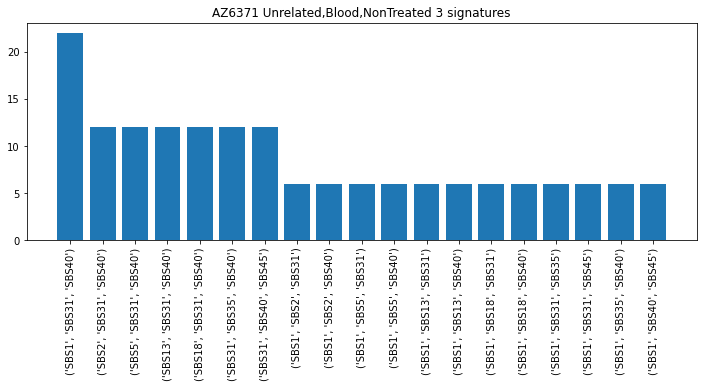

In [111]:
num_sigs = 3
best_sig_combinations (sample_ids, sample_dict,res_dict,num_sigs)

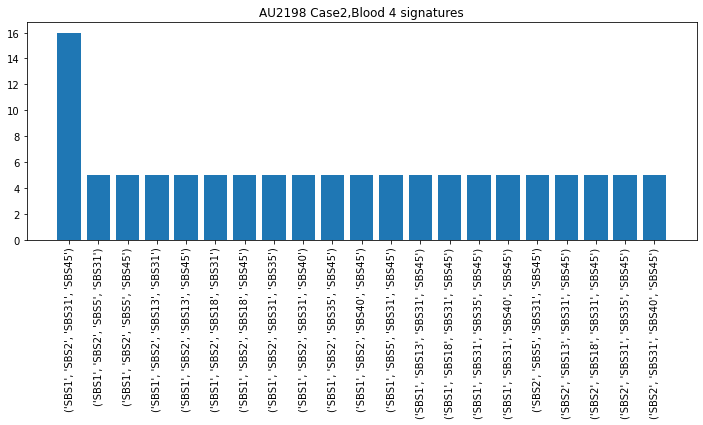

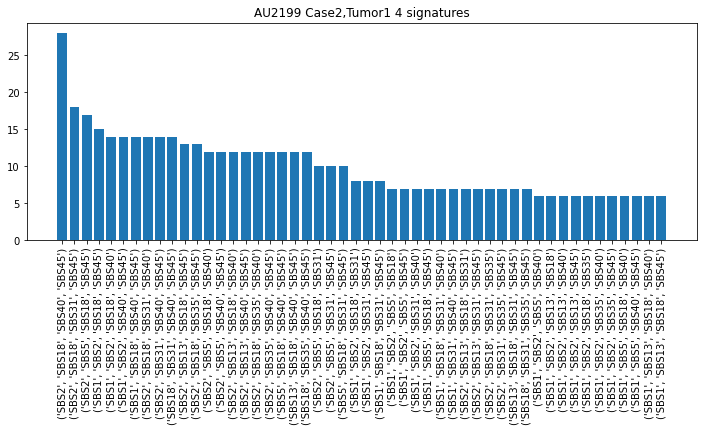

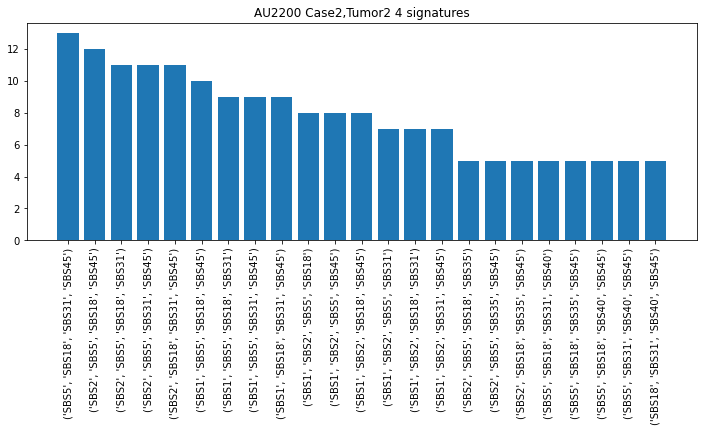

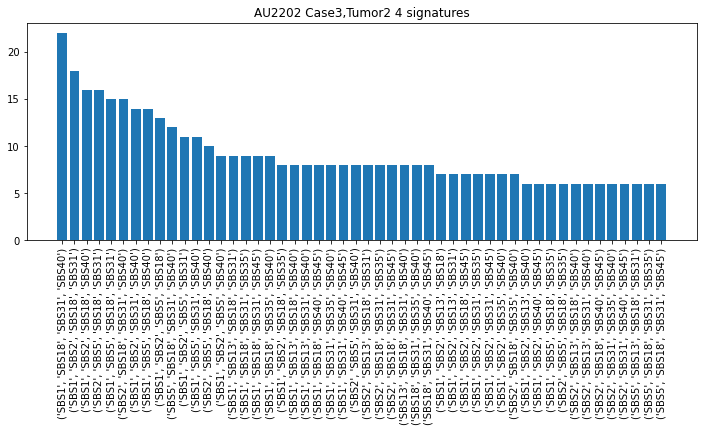

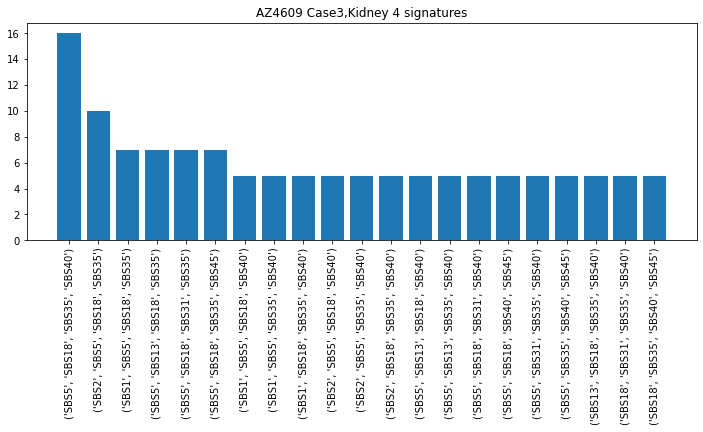

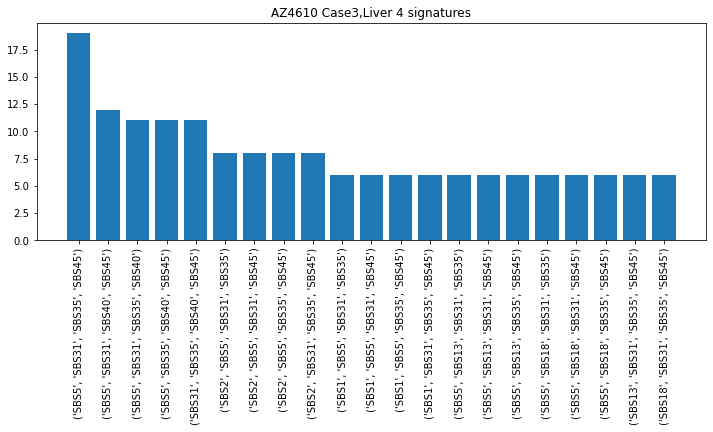

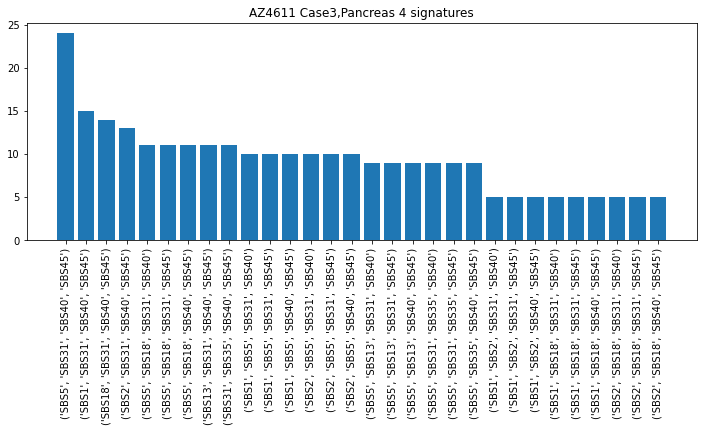

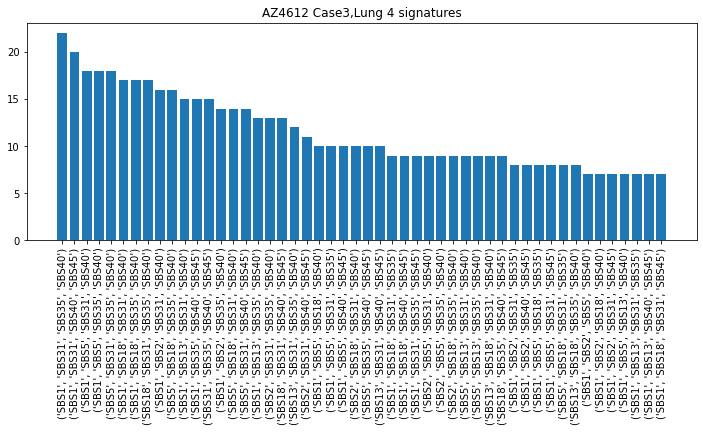

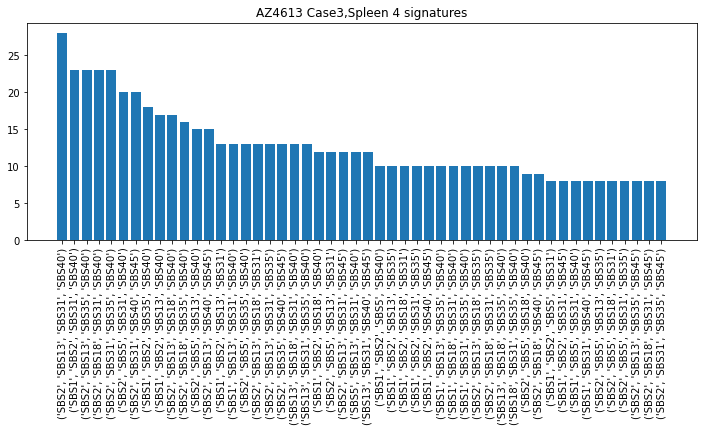

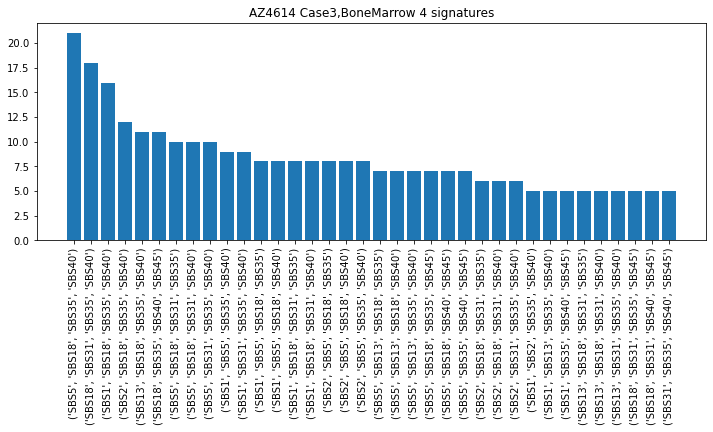

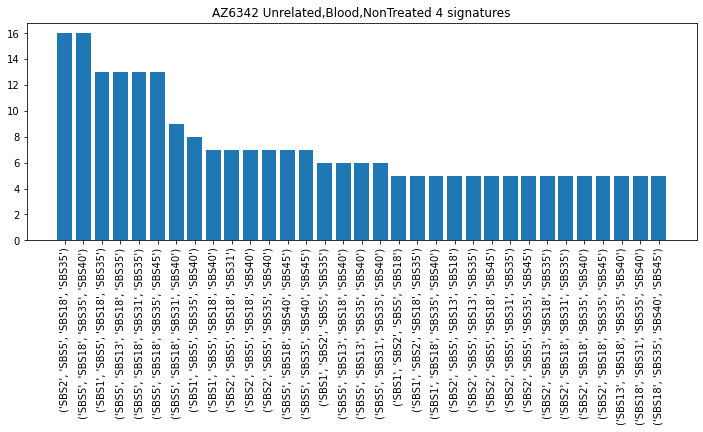

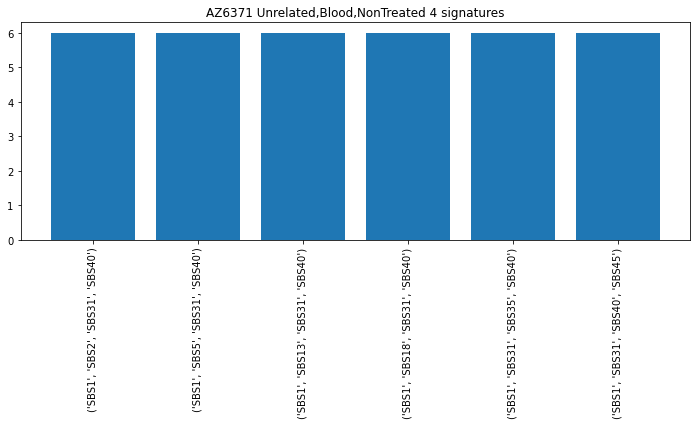

In [112]:
num_sigs = 4
best_sig_combinations (sample_ids, sample_dict,res_dict,num_sigs)

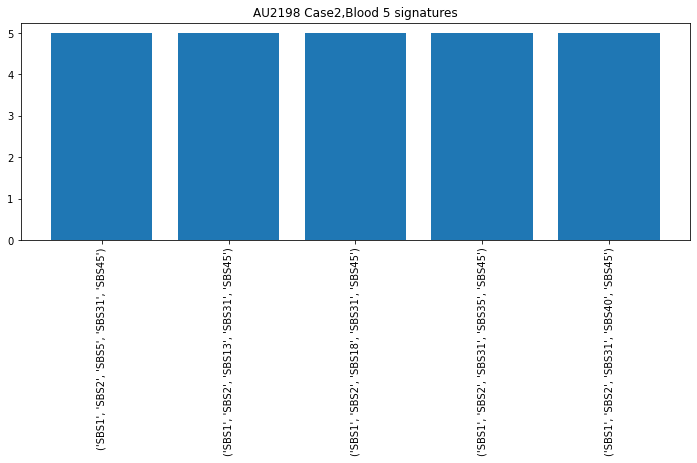

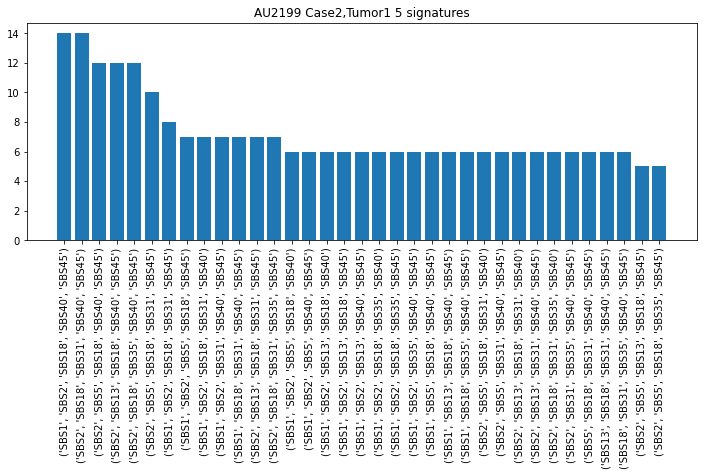

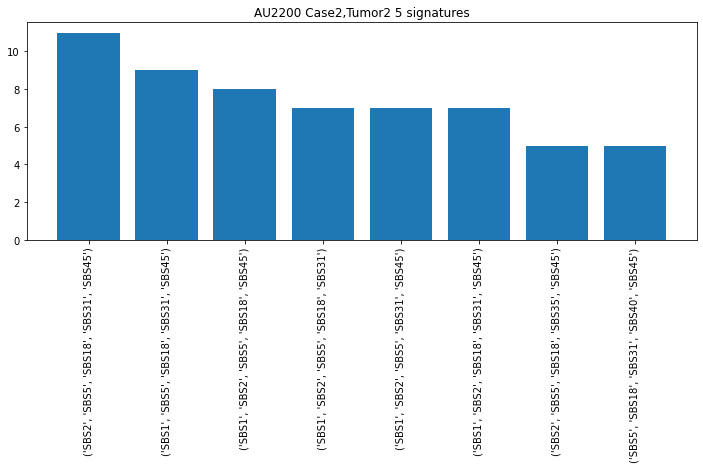

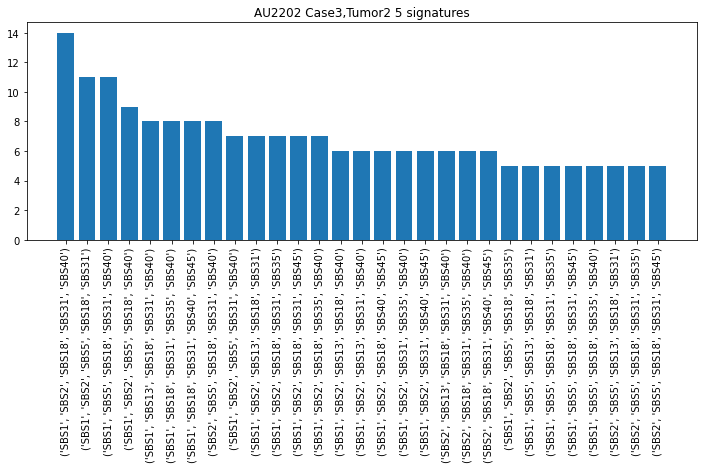

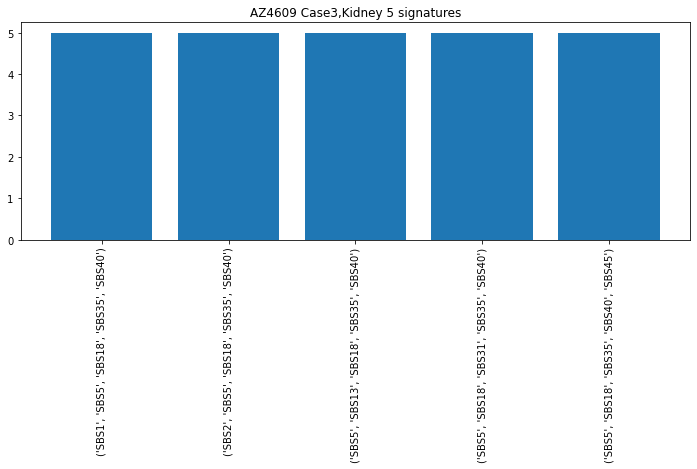

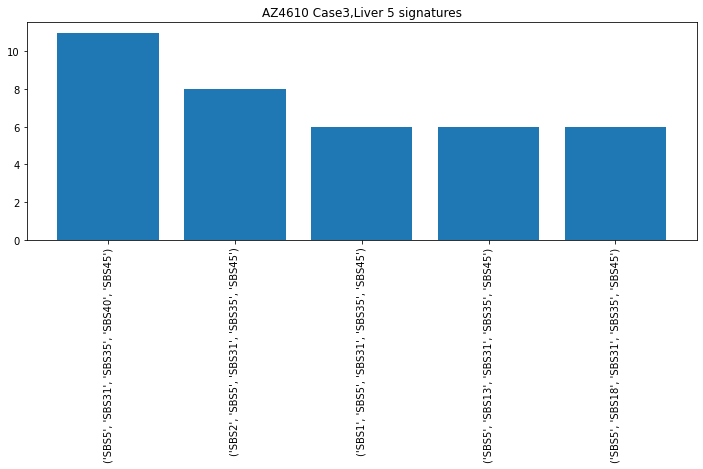

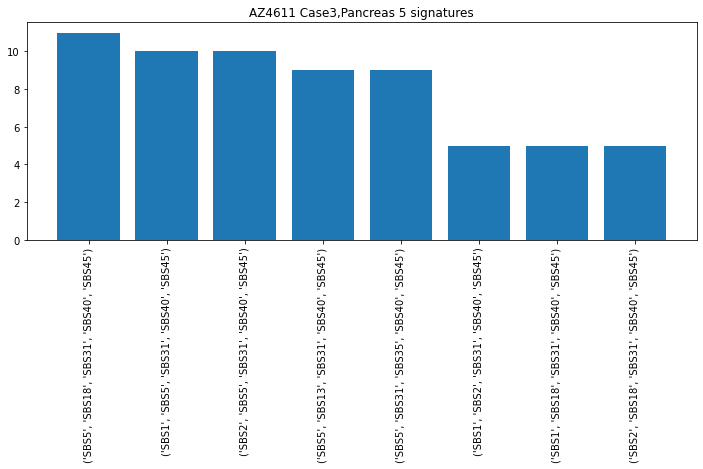

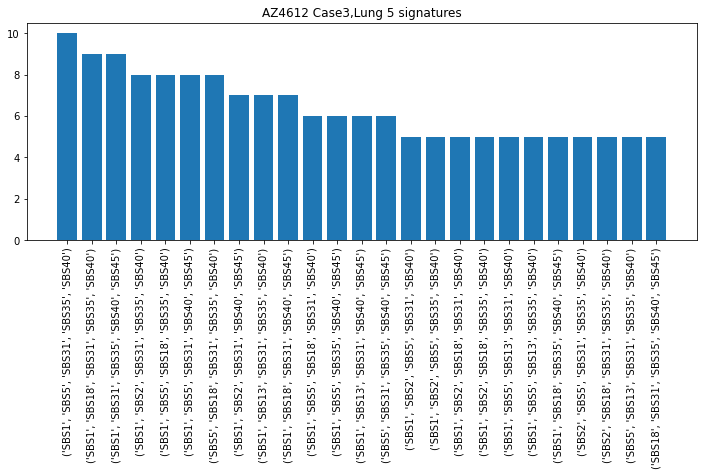

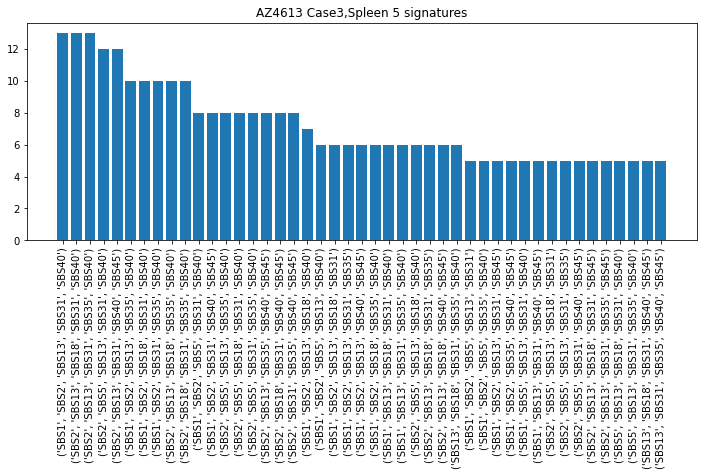

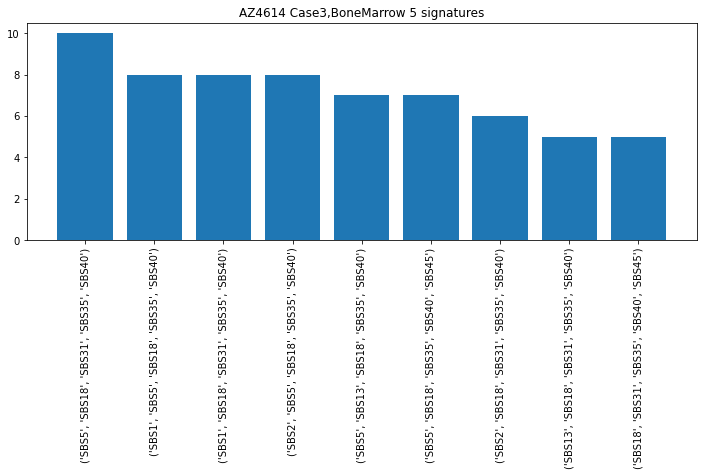

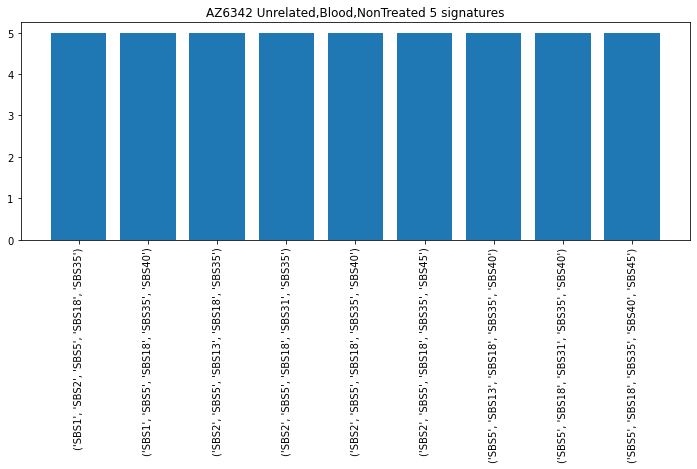

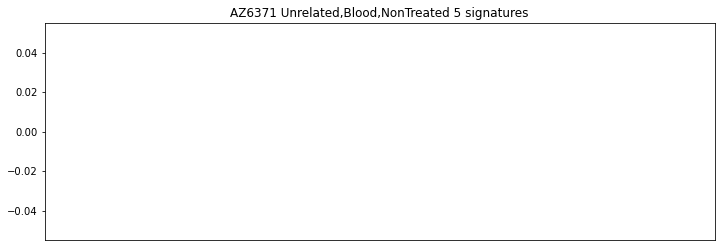

In [113]:
num_sigs = 5
best_sig_combinations (sample_ids, sample_dict,res_dict,num_sigs)

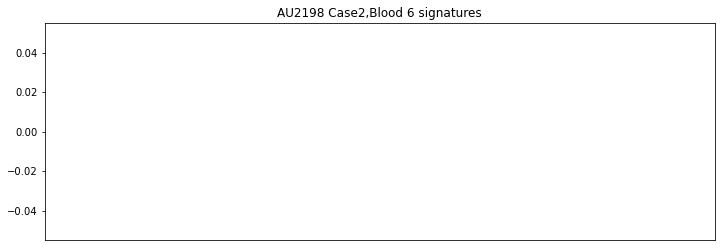

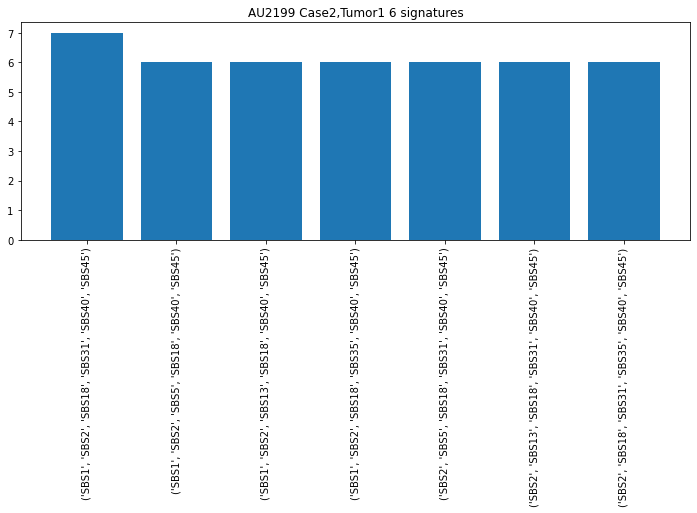

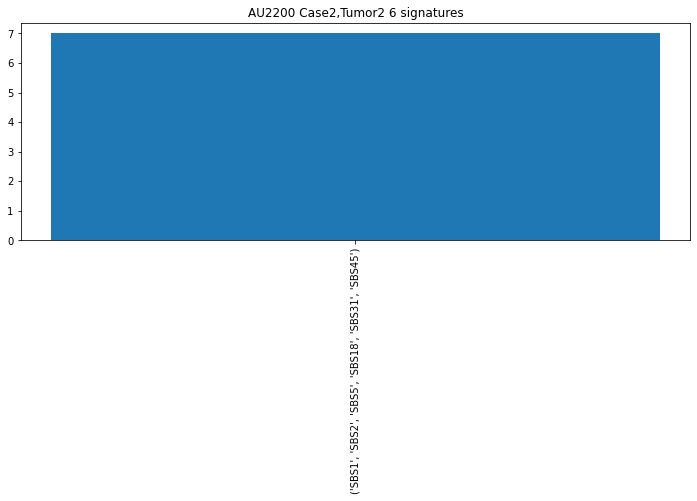

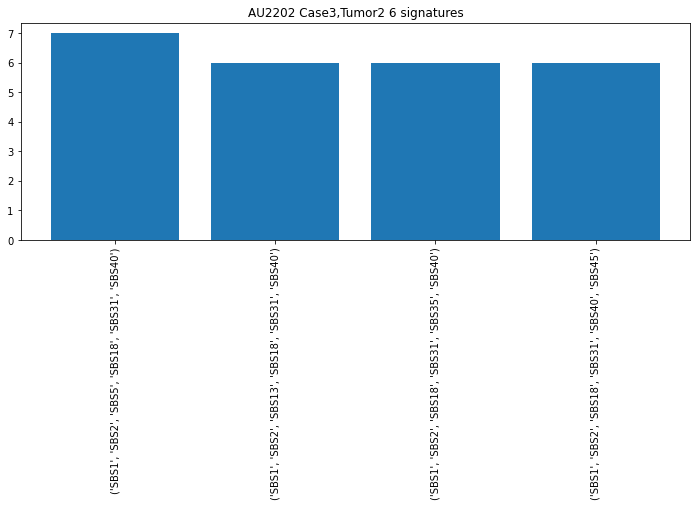

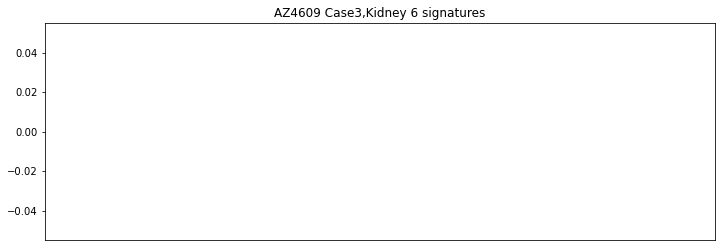

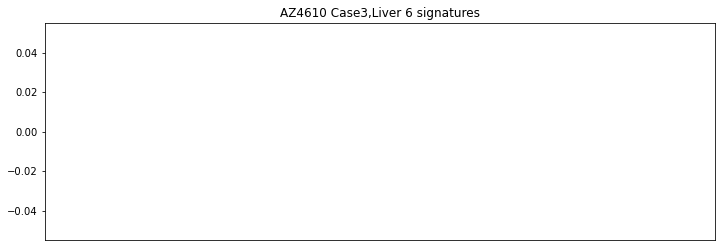

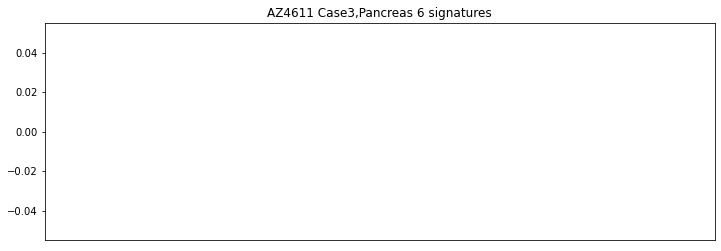

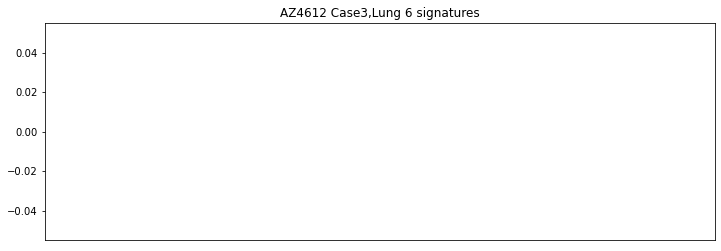

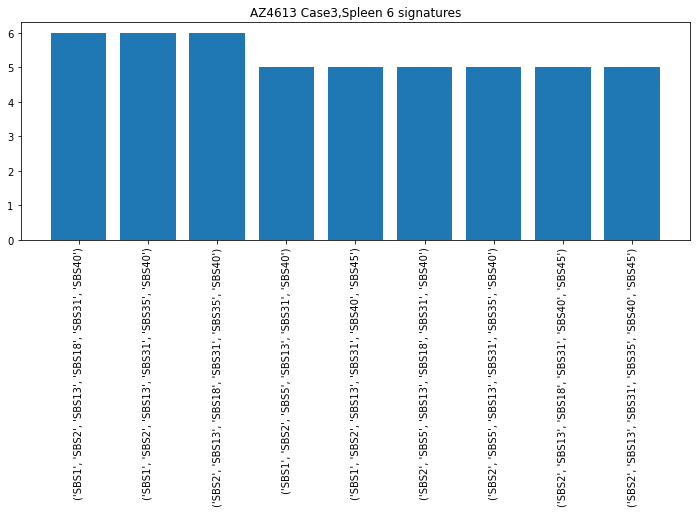

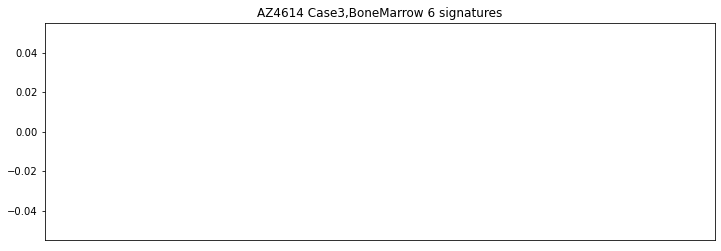

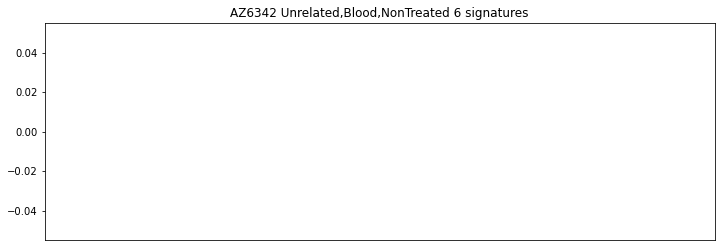

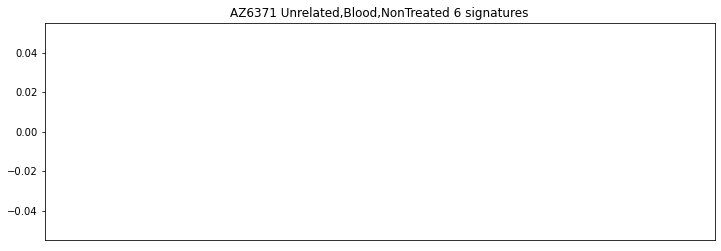

In [114]:
num_sigs = 6
best_sig_combinations (sample_ids, sample_dict,res_dict,num_sigs)

In [72]:
def check_aic (sample_id,signatures):
    tumor2_list = sorted(res_dict[sample_id],key=lambda x:x[2])
    aic_min=tumor2_list[0][2]
    res_sample = res_dict[sample_id]
    [ print((sample_id,r[0],'aic_min distance:',round((r[2]-aic_min),3))) for r in res_sample if r[0]==signatures]

In [116]:
#selection based on the combination of signatures with the best aic score and a manual curation

selected_sigs_dict = {'AU2198':['SBS1','SBS2','SBS31','SBS45'],
                       'AU2199':['SBS1','SBS2','SBS18','SBS31','SBS40','SBS45'],
                       'AU2200':['SBS1','SBS2','SBS5','SBS18','SBS31','SBS45'],
                       'AU2202':['SBS1','SBS2','SBS18','SBS31','SBS40'],
                       'AZ4609':['SBS5','SBS18','SBS31','SBS40','SBS45'],
                       'AZ4610':['SBS5','SBS31','SBS40','SBS45'],
                       'AZ4611':['SBS5','SBS31','SBS40','SBS45'],
                       'AZ4612':['SBS1','SBS31','SBS40'],
                       'AZ4613':['SBS2','SBS13','SBS31','SBS40'],
                       'AZ4614':['SBS5','SBS18','SBS31','SBS40'],
                       'AZ6342':['SBS5','SBS18','SBS31','SBS40'],
                       'AZ6371':['SBS1','SBS18','SBS31','SBS40']
                      }
for sample_id in selected_sigs_dict.keys():
    signatures = tuple(selected_sigs_dict[sample_id])
    check_aic (sample_id,signatures)

('AU2198', ('SBS1', 'SBS2', 'SBS31', 'SBS45'), 'aic_min distance:', 0.0)
('AU2199', ('SBS1', 'SBS2', 'SBS18', 'SBS31', 'SBS40', 'SBS45'), 'aic_min distance:', 0.396)
('AU2200', ('SBS1', 'SBS2', 'SBS5', 'SBS18', 'SBS31', 'SBS45'), 'aic_min distance:', 0.0)
('AU2202', ('SBS1', 'SBS2', 'SBS18', 'SBS31', 'SBS40'), 'aic_min distance:', 0.809)
('AZ4609', ('SBS5', 'SBS18', 'SBS31', 'SBS40', 'SBS45'), 'aic_min distance:', 14.971)
('AZ4610', ('SBS5', 'SBS31', 'SBS40', 'SBS45'), 'aic_min distance:', 4.259)
('AZ4611', ('SBS5', 'SBS31', 'SBS40', 'SBS45'), 'aic_min distance:', 0.0)
('AZ4612', ('SBS1', 'SBS31', 'SBS40'), 'aic_min distance:', 0.859)
('AZ4613', ('SBS2', 'SBS13', 'SBS31', 'SBS40'), 'aic_min distance:', 0.0)
('AZ4614', ('SBS5', 'SBS18', 'SBS31', 'SBS40'), 'aic_min distance:', 5.942)
('AZ6342', ('SBS5', 'SBS18', 'SBS31', 'SBS40'), 'aic_min distance:', 3.018)
('AZ6371', ('SBS1', 'SBS18', 'SBS31', 'SBS40'), 'aic_min distance:', 2.683)


In [117]:
file = './msigact/sigs_per_sample.json'
json.dump(selected_sigs_dict,open(file,'w'))